In [2]:
import torch

class BboxPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None
        self.gt = None
        self.currently_selecting = False
        self.x0, self.y0, self.x1, self.y1 = 0., 0., 0., 0.
        self.rect = None
        self.fig, self.axes = None, None
        self.segs = []

    def set_image(self, image):
        self.image = image
        self.img_size = image.shape[:2]
        image_preprocess = self._preprocess_image(image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)

    def _preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor
    
    @torch.no_grad()
    def infer(self, bbox):
        ori_H, ori_W = self.img_size
        scale_to_1024 = 1024 / np.array([ori_W, ori_H, ori_W, ori_H])
        bbox_1024 = bbox * scale_to_1024
        bbox_torch = torch.as_tensor(bbox_1024, dtype=torch.float).unsqueeze(0).to(self.model.device)
        if len(bbox_torch.shape) == 2:
            bbox_torch = bbox_torch.unsqueeze(1)
    
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=bbox_torch,
            masks=None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings = self.image_embeddings, # (B, 256, 64, 64)
            image_pe = self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings = sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )

        low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

        low_res_pred = F.interpolate(
            low_res_pred,
            size=self.img_size,
            mode="bilinear",
            align_corners=False,
        )  # (1, 1, gt.shape)
        low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
        medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
        return medsam_seg
    


In [3]:
# Test scrips
from segment_anything import sam_model_registry, SamPredictor

MedSAM_CKPT_PATH = "../../samm-workspace/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

bbox_prompt_demo = BboxPromptDemo(medsam_model)

In [15]:
import cv2
import numpy as np
from torch.nn import functional as F

img = 'test_img/img_demo.png'
image = cv2.imread(img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bbox_prompt_demo.set_image(image)
bbox = np.array([100, 100, 150, 230])
seg = bbox_prompt_demo.infer(bbox)

print(seg.max())

1


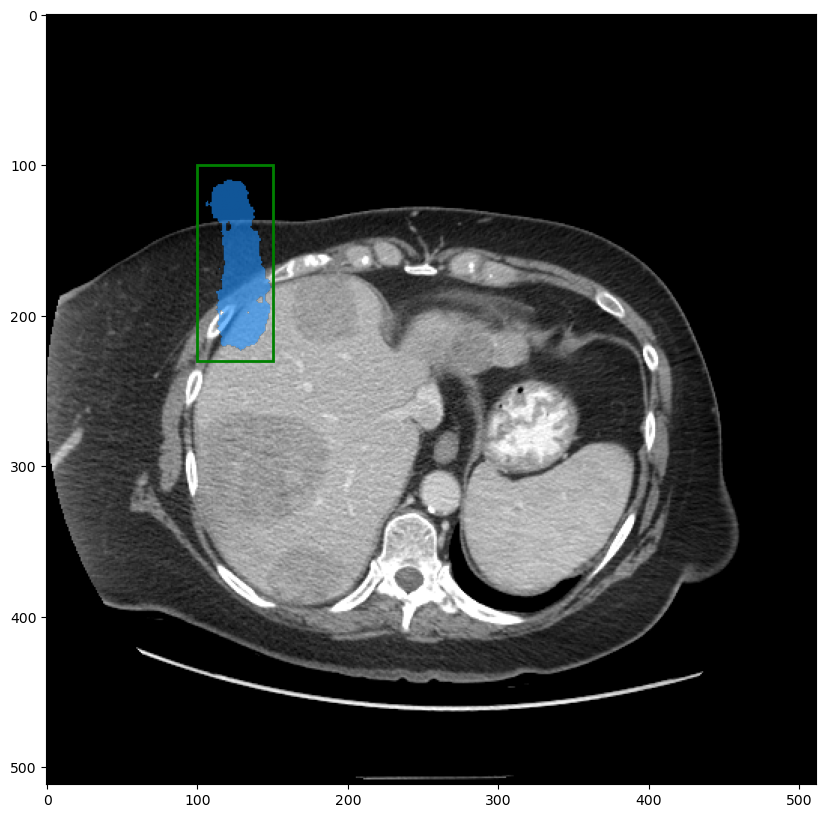

In [16]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

plt.figure(figsize=(10,10))
plt.imshow(image)

color = np.array([30/255, 144/255, 255/255, 0.6])
h, w = seg.shape[-2:]
mask_image = seg.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.imshow(mask_image)

show_box(bbox, plt.gca())

    
